In [1]:
#Import necessary functions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium


#For Time Series 
from datetime import datetime as dt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fbprophet import Prophet

In [3]:
df = pd.read_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2018_2023_V1.csv')
df.head()

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01 00:00:00,QUEENS,11419,40.68297,-73.82824,0,0,Passing Too Closely,3819067,Sedan,Moving Violation,Winter,Late Night,False
1,2018-01-01 00:00:00,BROOKLYN,11239,40.65306,-73.88202,0,0,Driver Inattention/Distraction,3820851,Sedan,Driver Error,Winter,Late Night,False
2,2018-01-01 00:00:00,BROOKLYN,11230,40.62418,-73.97048,0,0,Driver Inattention/Distraction,3822296,Station Wagon/Sport Utility Vehicle,Driver Error,Winter,Late Night,False
3,2018-01-01 00:00:00,BROOKLYN,11234,40.62877,-73.91825,1,0,Failure to Yield Right-of-Way,3820945,Sedan,Moving Violation,Winter,Late Night,False
4,2018-01-01 00:00:00,BROOKLYN,11230,40.62322,-73.96102,0,0,Driver Inattention/Distraction,3821055,Taxi,Driver Error,Winter,Late Night,False


In [4]:
df_2023 = pd.read_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2023_V1.csv')
df_2023

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2023-01-01 00:00:00,QUEENS,11101,40.745068,-73.936356,0,0,Driver Inattention/Distraction,4599239,Station Wagon/Sport Utility Vehicle,Driver Error,Winter,Late Night,False
1,2023-01-01 00:34:00,QUEENS,11435,40.713543,-73.812640,1,0,Alcohol Involvement,4594890,Sedan,Bodily Impairment,Winter,Late Night,False
2,2023-01-01 00:35:00,BROOKLYN,11229,40.601310,-73.954720,0,0,Backing Unsafely,4594332,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
3,2023-01-01 01:10:00,BROOKLYN,11223,40.593760,-73.982740,2,0,Unsafe Speed,4594435,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
4,2023-01-01 01:17:00,QUEENS,11375,40.724308,-73.842575,0,0,Alcohol Involvement,4595209,Sedan,Bodily Impairment,Winter,Late Night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6146,2023-03-27 20:44:00,BROOKLYN,11238,40.670660,-73.957985,1,0,Driver Inattention/Distraction,4616538,Station Wagon/Sport Utility Vehicle,Driver Error,Spring,Night,False
6147,2023-03-27 21:50:00,QUEENS,11385,40.709038,-73.898460,1,0,Failure to Yield Right-of-Way,4616419,Moped,Moving Violation,Spring,Night,False
6148,2023-03-27 22:10:00,BROOKLYN,11218,40.640410,-73.969124,1,0,Driver Inattention/Distraction,4616379,Sedan,Driver Error,Spring,Night,False
6149,2023-03-27 23:07:00,BROOKLYN,11218,40.640316,-73.979070,0,0,Backing Unsafely,4616380,Box Truck,Moving Violation,Spring,Night,False


#### Changing DateTime Index

In [5]:
#Change column to datetime datatype
df['CRASH DATE TIME'] = pd.to_datetime(df['CRASH DATE TIME'])
df_2023['CRASH DATE TIME'] = pd.to_datetime(df_2023['CRASH DATE TIME'])

In [6]:
ts = df.copy()
ts_2023 = df_2023.copy()
ts.head()

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01,QUEENS,11419,40.68297,-73.82824,0,0,Passing Too Closely,3819067,Sedan,Moving Violation,Winter,Late Night,False
1,2018-01-01,BROOKLYN,11239,40.65306,-73.88202,0,0,Driver Inattention/Distraction,3820851,Sedan,Driver Error,Winter,Late Night,False
2,2018-01-01,BROOKLYN,11230,40.62418,-73.97048,0,0,Driver Inattention/Distraction,3822296,Station Wagon/Sport Utility Vehicle,Driver Error,Winter,Late Night,False
3,2018-01-01,BROOKLYN,11234,40.62877,-73.91825,1,0,Failure to Yield Right-of-Way,3820945,Sedan,Moving Violation,Winter,Late Night,False
4,2018-01-01,BROOKLYN,11230,40.62322,-73.96102,0,0,Driver Inattention/Distraction,3821055,Taxi,Driver Error,Winter,Late Night,False


### Groupby Daily

In [7]:
#Group the values by day and count the number of instances of each value
daily_count = ts.groupby([ts['CRASH DATE TIME'].dt.date, 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')
daily2023_count = ts_2023.groupby([ts_2023['CRASH DATE TIME'].dt.date, 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

#Print the result
print(daily_count)

      CRASH DATE TIME CONTRIBUTING CATEGORY V1  count
0          2018-01-01        Bodily Impairment      4
1          2018-01-01             Driver Error     45
2          2018-01-01    Environmental Factors      2
3          2018-01-01         Moving Violation     72
4          2018-01-01       Other Distractions      2
...               ...                      ...    ...
12954      2022-12-31        Bodily Impairment      6
12955      2022-12-31             Driver Error     29
12956      2022-12-31    Environmental Factors      4
12957      2022-12-31         Moving Violation     34
12958      2022-12-31  Third-Party (Vehicular)      2

[12959 rows x 3 columns]


In [8]:
#Create pivot table of daily cause categories
ts_pivt = daily_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)
ts2023_pivt = daily2023_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)


ts_pivt.head(10)

CONTRIBUTING CATEGORY V1,Bodily Impairment,Driver Error,Environmental Factors,Internal Electronics Usage,Moving Violation,Other Distractions,Road Conditions,Third-Party (Non-Vehicular),Third-Party (Vehicular),Vehicle Defects
CRASH DATE TIME,,,,,,,,,,
2018-01-01,4.0,45.0,2.0,0.0,72.0,2.0,5.0,0.0,5.0,1.0
2018-01-02,1.0,73.0,8.0,0.0,83.0,3.0,3.0,2.0,9.0,6.0
2018-01-03,3.0,86.0,2.0,1.0,105.0,1.0,0.0,3.0,8.0,1.0
2018-01-04,4.0,25.0,2.0,0.0,43.0,0.0,46.0,0.0,4.0,3.0
2018-01-05,2.0,53.0,4.0,0.0,114.0,0.0,45.0,0.0,7.0,2.0
2018-01-06,3.0,44.0,2.0,0.0,75.0,1.0,22.0,1.0,4.0,3.0
2018-01-07,4.0,32.0,3.0,0.0,66.0,1.0,10.0,1.0,4.0,2.0
2018-01-08,2.0,77.0,4.0,0.0,115.0,0.0,7.0,0.0,9.0,1.0
2018-01-09,4.0,60.0,4.0,0.0,105.0,1.0,6.0,2.0,9.0,0.0


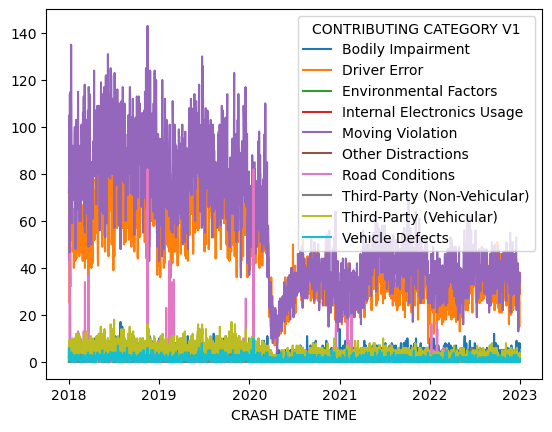

In [9]:
ts_pivt.plot();

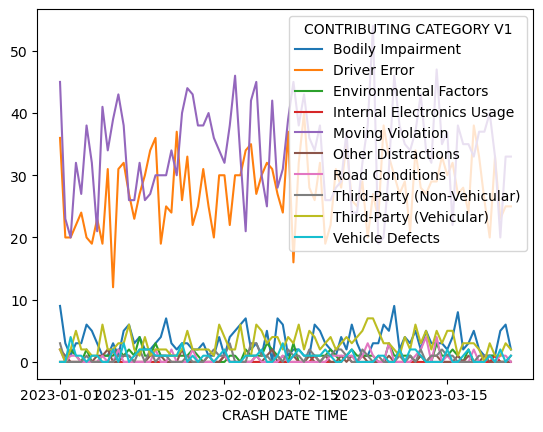

In [10]:
ts2023_pivt.plot();

In [11]:
#Converting the index as datetime index
ts_pivt.index = pd.to_datetime(ts_pivt.index)
ts2023_pivt.index = pd.to_datetime(ts2023_pivt.index)

In [12]:
#Select highest causes of collision
ts_mv = ts_pivt[['Moving Violation']]
ts_mv

CONTRIBUTING CATEGORY V1,Moving Violation
CRASH DATE TIME,
2018-01-01,72.0
2018-01-02,83.0
2018-01-03,105.0
2018-01-04,43.0
2018-01-05,114.0
...,...
2022-12-27,27.0
2022-12-28,31.0
2022-12-29,29.0


In [13]:
#
ts2023_mv = ts2023_pivt[['Moving Violation']]
ts2023_mv

CONTRIBUTING CATEGORY V1,Moving Violation
CRASH DATE TIME,
2023-01-01,45.0
2023-01-02,23.0
2023-01-03,20.0
2023-01-04,32.0
2023-01-05,27.0
...,...
2023-03-23,40.0
2023-03-24,33.0
2023-03-25,20.0


# Prophet

In [16]:
furniture = ts_mv.reset_index()
furniture

CONTRIBUTING CATEGORY V1,CRASH DATE TIME,Moving Violation
0,2018-01-01,72.0
1,2018-01-02,83.0
2,2018-01-03,105.0
3,2018-01-04,43.0
4,2018-01-05,114.0
...,...,...
1821,2022-12-27,27.0
1822,2022-12-28,31.0
1823,2022-12-29,29.0
1824,2022-12-30,38.0


Initial log joint probability = -21.6899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3470.22    0.00504395       118.638           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3495.2     0.0771079       305.336      0.2076           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       3509.74   0.000426743       248.118    3.58e-06       0.001      435  LS failed, Hessian reset 
     299       3509.85    0.00177628       131.905           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3512.59   0.000715497       97.6122      0.5338      0.5338      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       3515.65   0.000405216    

<Figure size 1800x600 with 0 Axes>

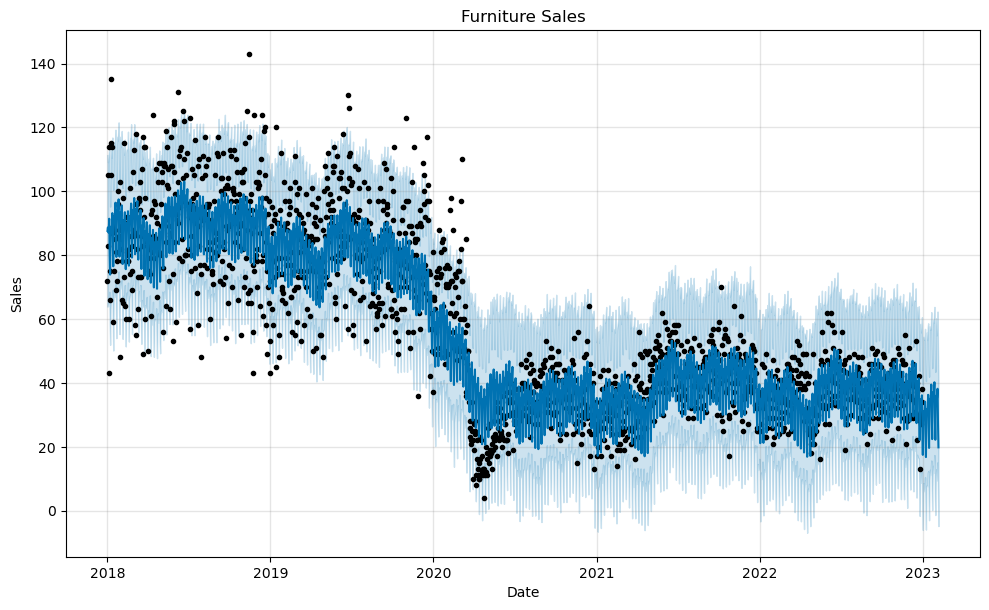

In [23]:
furniture = furniture.rename(columns={'CRASH DATE TIME': 'ds', 'Moving Violation': 'y'})
furniture_model = Prophet(interval_width=0.95, daily_seasonality=True)
#furniture_model.add_seasonality(name='daily', period=30.5, fourier_order=5)

furniture_model.fit(furniture)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='D')
furniture_forecast = furniture_model.predict(furniture_forecast)

plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

In [26]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_furniture_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,75.803777,63.864905,111.366345,75.803777,75.803777,11.773261,11.773261,11.773261,16.584852,...,1.544669,1.544669,1.544669,-6.356259,-6.356259,-6.356259,0.0,0.0,0.0,87.577038
1,2018-01-02,75.788035,65.123757,109.141218,75.788035,75.788035,12.867270,12.867270,12.867270,16.584852,...,2.986544,2.986544,2.986544,-6.704125,-6.704125,-6.704125,0.0,0.0,0.0,88.655305
2,2018-01-03,75.772293,64.151090,110.387304,75.772293,75.772293,11.338682,11.338682,11.338682,16.584852,...,1.711349,1.711349,1.711349,-6.957519,-6.957519,-6.957519,0.0,0.0,0.0,87.110974
3,2018-01-04,75.756551,65.033820,111.768437,75.756551,75.756551,12.619902,12.619902,12.619902,16.584852,...,3.149335,3.149335,3.149335,-7.114285,-7.114285,-7.114285,0.0,0.0,0.0,88.376453
4,2018-01-05,75.740809,68.514129,113.781253,75.740809,75.740809,15.649323,15.649323,15.649323,16.584852,...,6.238849,6.238849,6.238849,-7.174378,-7.174378,-7.174378,0.0,0.0,0.0,91.390132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,2023-02-01,18.149169,9.429709,54.898858,17.560882,18.858585,16.192421,16.192421,16.192421,16.584852,...,1.711349,1.711349,1.711349,-2.103779,-2.103779,-2.103779,0.0,0.0,0.0,34.341590
1858,2023-02-02,18.137891,12.121511,57.531169,17.514868,18.885947,17.282309,17.282309,17.282309,16.584852,...,3.149335,3.149335,3.149335,-2.451878,-2.451878,-2.451878,0.0,0.0,0.0,35.420200
1859,2023-02-03,18.126613,15.121067,62.336681,17.489957,18.907063,20.015569,20.015569,20.015569,16.584852,...,6.238849,6.238849,6.238849,-2.808132,-2.808132,-2.808132,0.0,0.0,0.0,38.142182
1860,2023-02-04,18.115335,5.248217,51.178480,17.439584,18.928049,9.177885,9.177885,9.177885,16.584852,...,-4.245426,-4.245426,-4.245426,-3.161541,-3.161541,-3.161541,0.0,0.0,0.0,27.293220


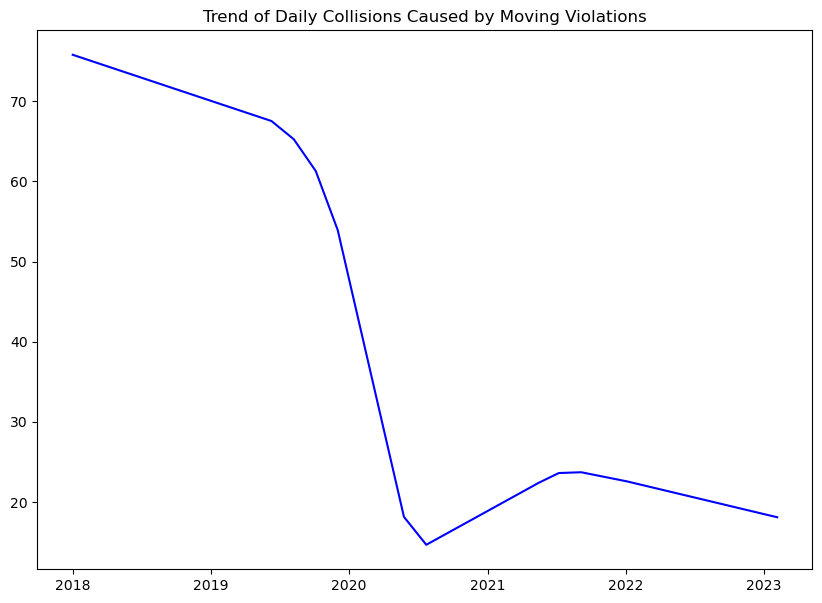

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(merge_furniture_forecast['ds'], merge_furniture_forecast['trend'], 'b-')
plt.title('Trend of Daily Collisions Caused by Moving Violations');

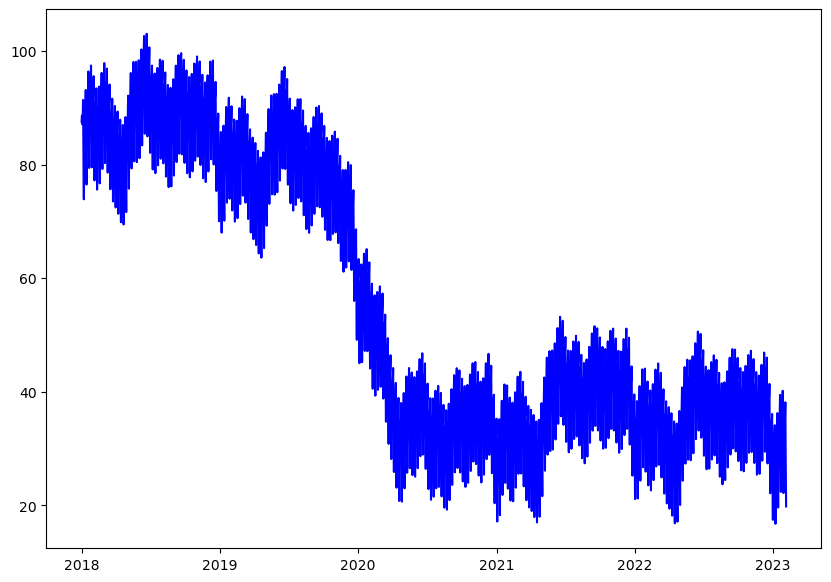

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(merge_furniture_forecast['ds'], merge_furniture_forecast['yhat'], 'b-');

## Train Test Split

In [21]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_mv.shape[0]*0.8) #cut off point at 80% of the data
cutoff

1461

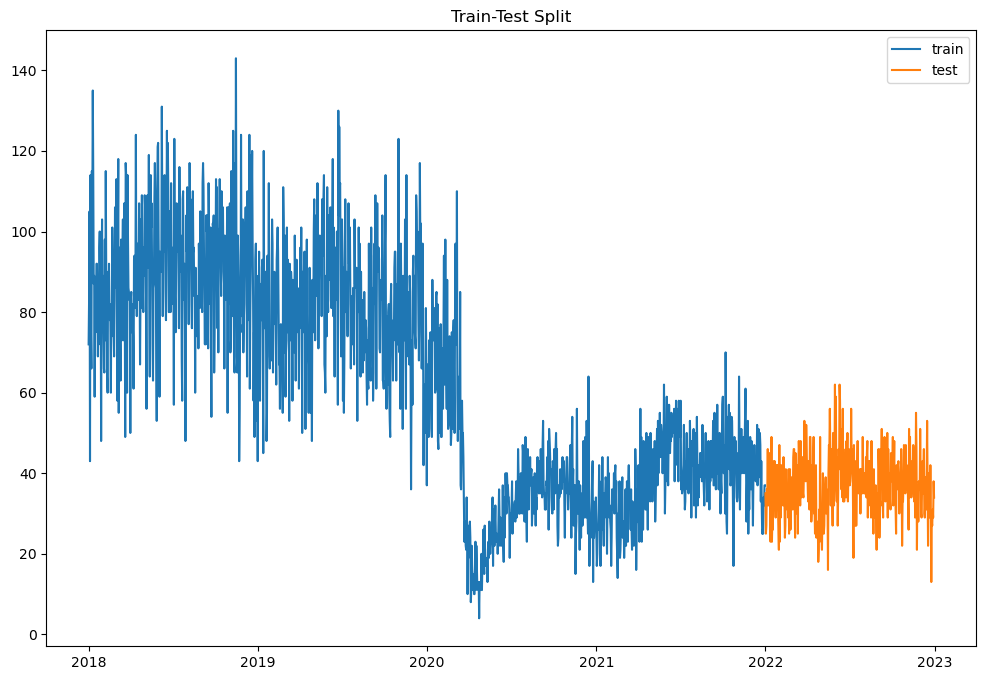

In [22]:
# Define train and test sets according to the index found above
train = ts_mv[:cutoff] #before cut off is train set -- 80%

test = ts_mv[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

Source: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

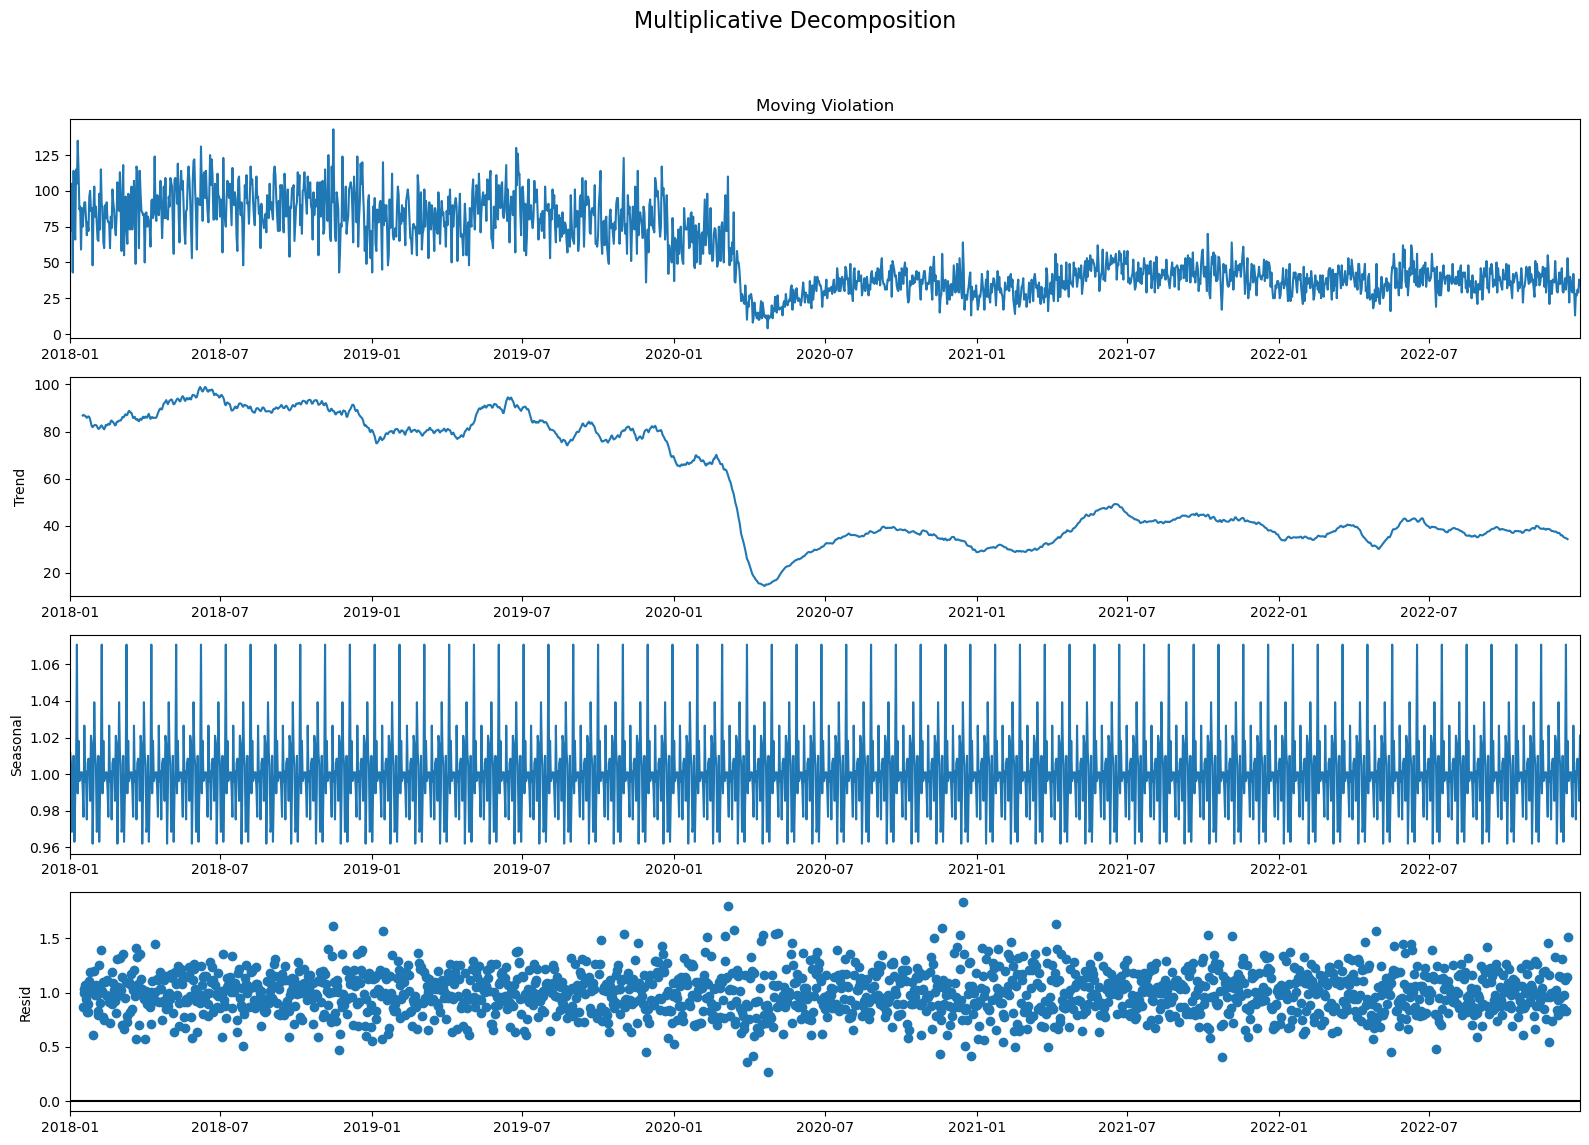

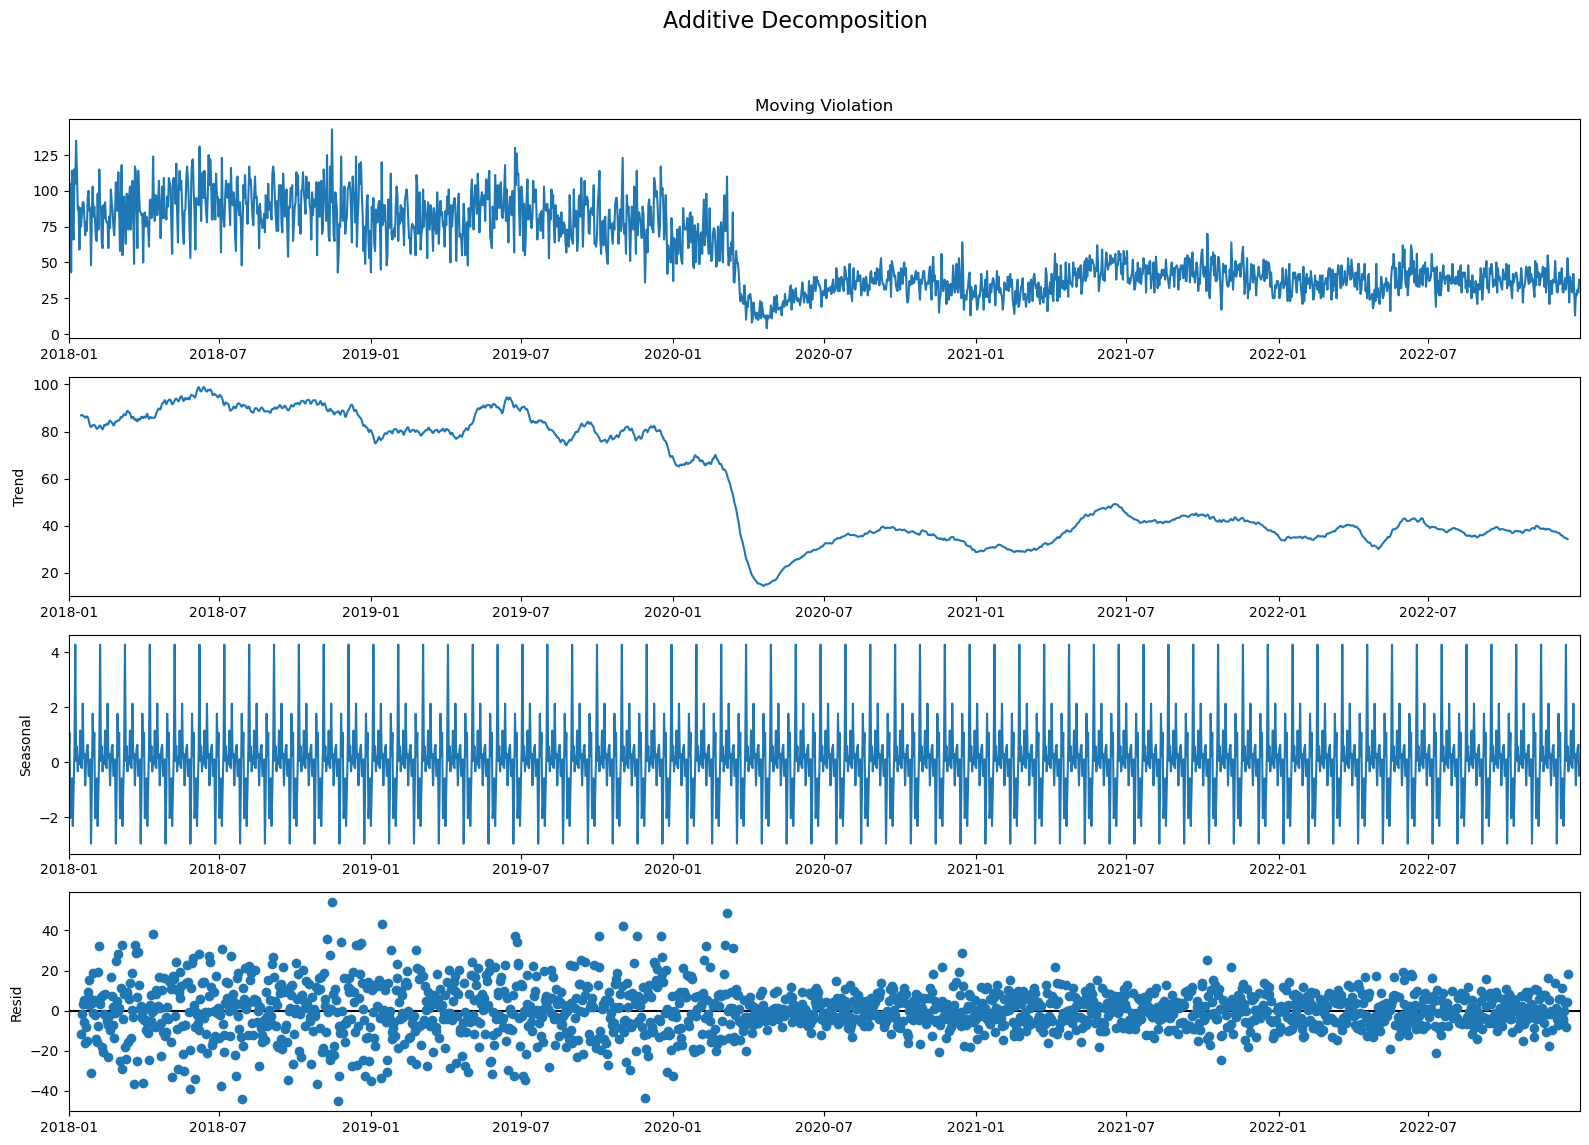

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(ts_mv['Moving Violation'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(ts_mv['Moving Violation'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Baseline Model
The baseline model is a naive model, which is just one shift in time by one period in time and in this case, it would be by 1 week. The metric that will be used to determine the quality and effectiveness of the model will be Root Mean Squared Error (RMSE). 

In [24]:
#
baseline = train.copy()
baseline['One Shift'] = train.shift(1)
baseline

CONTRIBUTING CATEGORY V1,Moving Violation,One Shift
CRASH DATE TIME,,
2018-01-01,72.0,NaN
2018-01-02,83.0,72.0
2018-01-03,105.0,83.0
2018-01-04,43.0,105.0
2018-01-05,114.0,43.0
...,...,...
2021-12-27,25.0,26.0
2021-12-28,34.0,25.0
2021-12-29,32.0,34.0


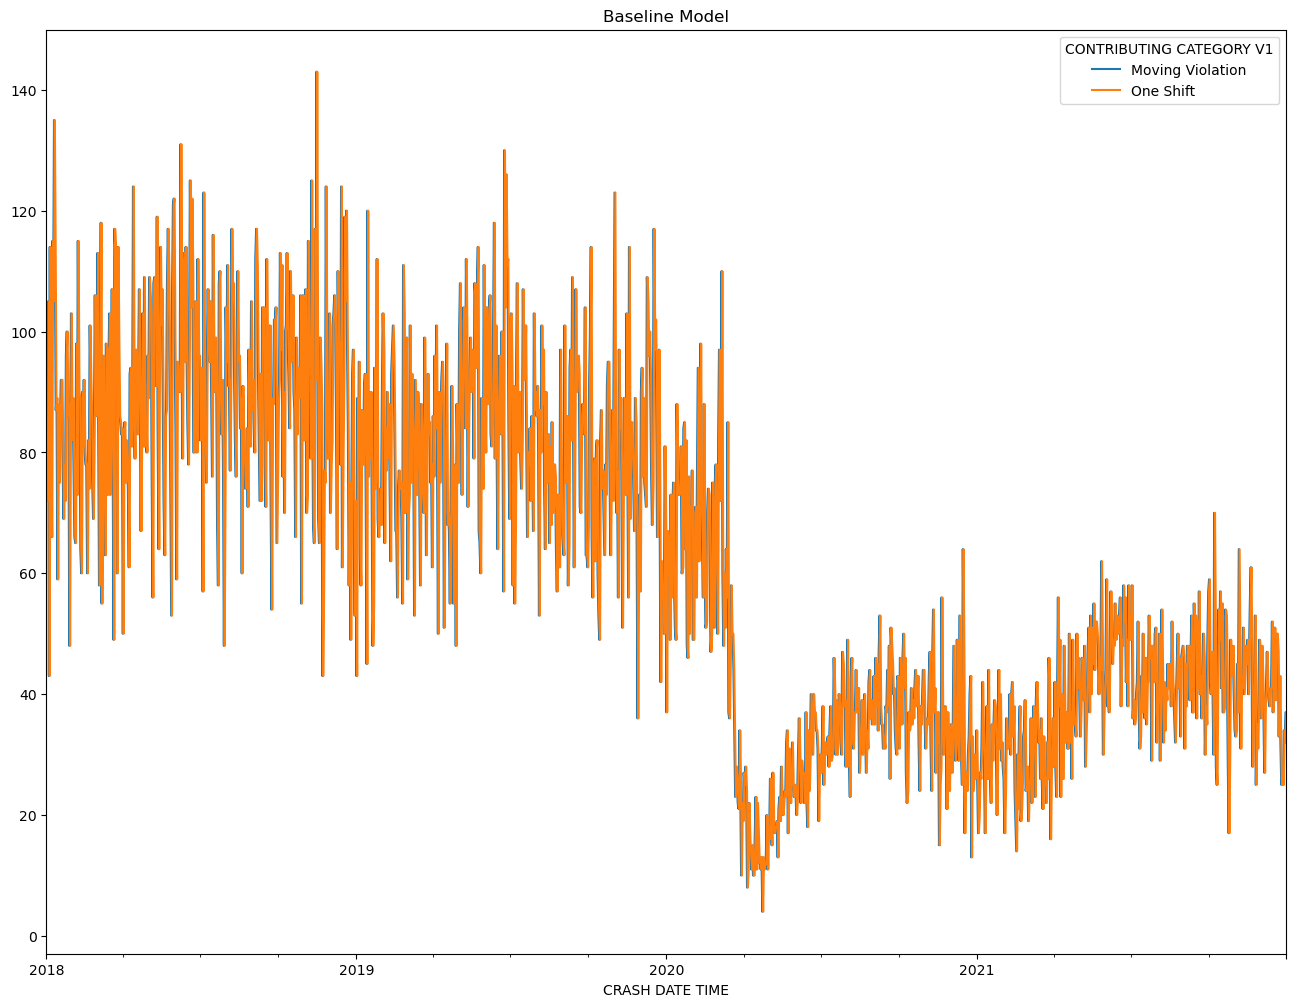

In [25]:
#
baseline.plot()
plt.title('Baseline Model');

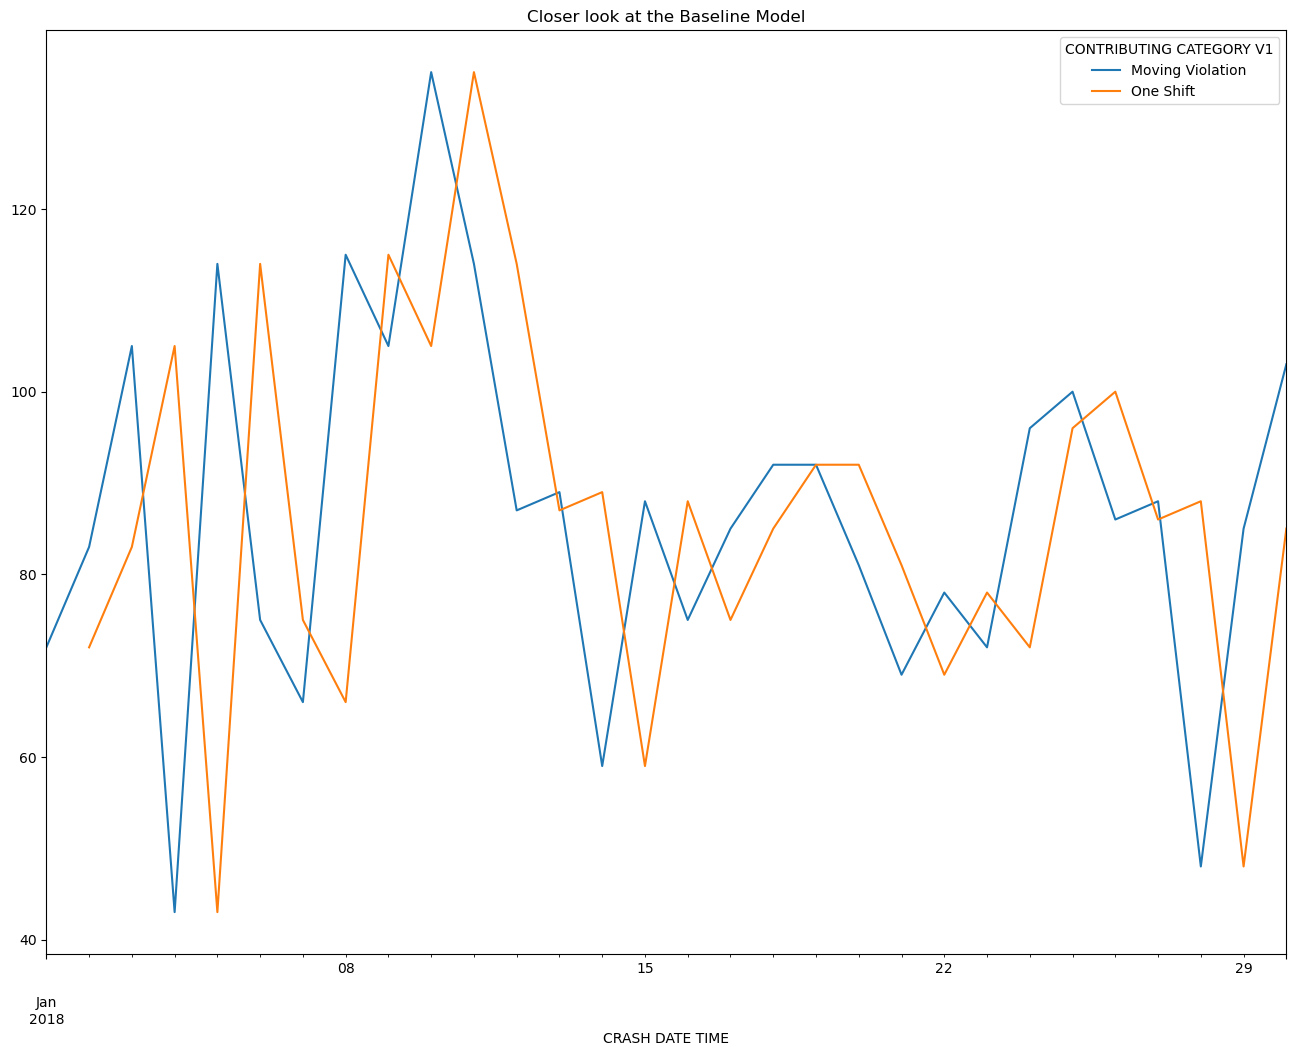

In [26]:
#A closer look
baseline[0:30].plot()
plt.title('Closer look at the Baseline Model');

In [27]:
#Calculate the Root Mean Square Error of the baseline model
baseline_rmse = np.sqrt(mean_squared_error(baseline['Moving Violation'][1:], baseline['One Shift'].dropna()))

print(f'Baseline Model RMSE: {baseline_rmse}')

Baseline Model RMSE: 17.031095654070004
